In [ ]:
##############Out focusing stuff for human & animal

In [ ]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
import matplotlib.pyplot as plt
from PIL import Image # Using PIL for consistency with torchvision transforms

def segment_and_blur_background(
    image_path: str,
    target_class_id: int = 15, # Default to 15 (person for COCO dataset)
    blur_strength: int = 25,
    output_path: str = None,
    show_result: bool = True
) -> np.ndarray:
    """
    Performs semantic segmentation on an image, identifies a target object,
    and applies a blur to the background ("outfocusing" or bokeh effect).

    Args:
        image_path: Path to the image to process.
        target_class_id: The class ID of the object to keep in focus
                         (default is 15 for 'person').
        blur_strength: The kernel size for the background blur.
                         Higher numbers mean more blur.
        output_path: Optional path to save the resulting image. If None, not saved.
        show_result: If True, displays the resulting image using matplotlib.

    Returns:
        The resulting image with a blurred background as an RGB NumPy array.
    """
    
    # --- 1. Setup Device and Model ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Use the recommended 'weights' parameter to load the model and transforms
    weights = DeepLabV3_ResNet101_Weights.DEFAULT # COCO_WITH_VOC_LABELS_V1
    model = deeplabv3_resnet101(weights=weights).eval().to(device)
    transforms = weights.transforms() # Get transforms associated with weights

    # --- 2. Load and Preprocess Image ---
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Could not load image: {image_path}")

        # Convert BGR (OpenCV) to RGB (Matplotlib, PIL, Torch)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        original_h, original_w = img_rgb.shape[:2]
        print(f"Original image size: ({original_h}, {original_w})")
    
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

    # --- 3. Prepare Input Tensor for Model ---
    # Use PIL Image for torchvision transforms
    pil_img = Image.fromarray(img_rgb)
    input_tensor = transforms(pil_img).unsqueeze(0).to(device)

    # --- 4. Perform Segmentation ---
    try:
        with torch.no_grad():
            output = model(input_tensor)["out"][0]
            output_predictions = output.argmax(0).byte().cpu().numpy()
        print(f"Inference mask size (before resize): {output_predictions.shape}")
    
    except Exception as e:
        print(f"Error during model inference: {e}")
        return None

    # --- 5. Process Mask ---
    # Resize mask to original image size using NEAREST interpolation
    output_predictions_resized = cv2.resize(
        output_predictions, (original_w, original_h), interpolation=cv2.INTER_NEAREST
    )
    
    # --- ADDED: Print detected classes as requested ---
    unique_classes = np.unique(output_predictions_resized)
    print(f"Detected class IDs in the image: {unique_classes}")
    # Common IDs: 0=background, 8=cat, 15=person, 16=dog

    # Create binary mask for the target class
    seg_map = (output_predictions_resized == target_class_id)
    img_mask = seg_map.astype(np.uint8) * 255

    # --- 6. Create Blurred Background and Combine ---
    
    # Create the blurred version of the original image
    # Ensure blur_strength is odd for some blur types, but for cv2.blur it's fine
    blur_kernel = (blur_strength, blur_strength)
    img_blurred = cv2.blur(img_rgb, blur_kernel)

    # Convert single-channel mask to 3-channel
    # (cv2.COLOR_GRAY2RGB or GRAY2BGR both just copy the value to all 3 channels)
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2RGB)

    # Combine using the mask:
    # Where mask is 255 (white), use original image
    # Where mask is 0 (black), use blurred image
    result_img = np.where(img_mask_color == 255, img_rgb, img_blurred)
    print("Combining complete.")

    # --- 7. Save and/or Show Result ---
    if output_path:
        try:
            # Convert back to BGR for saving with OpenCV (Fixes bug from notebook)
            result_img_bgr = cv2.cvtColor(result_img.astype(np.uint8), cv2.COLOR_RGB2BGR)
            cv2.imwrite(output_path, result_img_bgr)
            print(f"Result saved to {output_path}")
        except Exception as e:
            print(f"Error saving image: {e}")

    if show_result:
        plt.figure(figsize=(8, 8))
        plt.imshow(result_img)
        plt.title("Image with Blurred Background")
        plt.axis('off')
        plt.show()

    return result_img.astype(np.uint8)

Using device: cpu
Original image size: (602, 480)
Inference mask size (before resize): (652, 520)
Detected class IDs in the image: [ 0 15]
Combining complete.


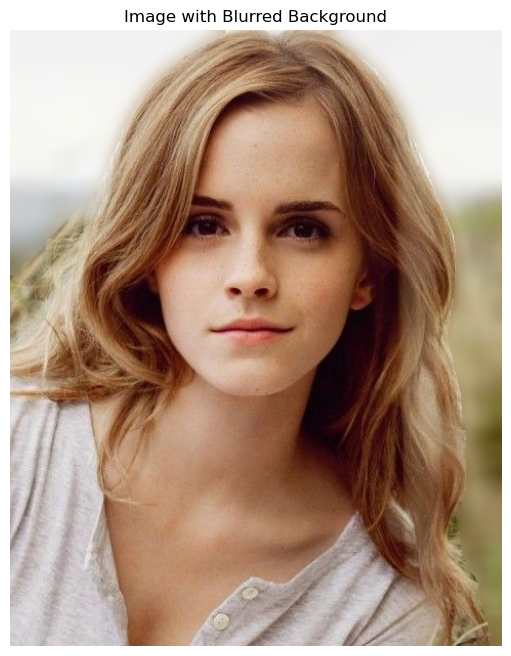

Using device: cpu
Original image size: (194, 260)
Inference mask size (before resize): (520, 696)
Detected class IDs in the image: [ 0 10]
Combining complete.


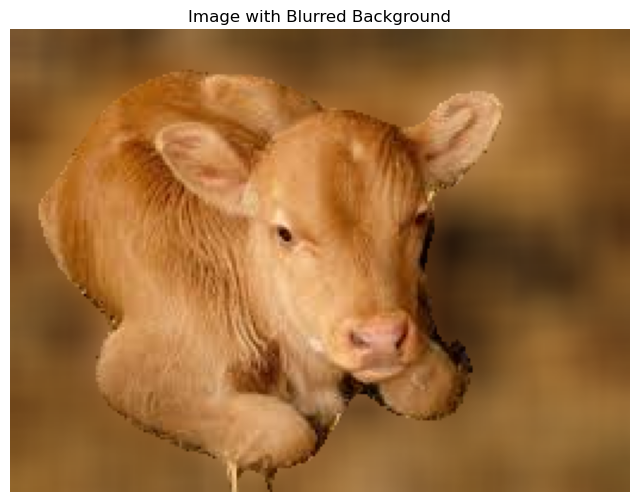

array([[[121,  86,  48],
        [121,  86,  48],
        [121,  86,  48],
        ...,
        [119,  80,  32],
        [118,  80,  32],
        [118,  79,  32]],

       [[122,  86,  48],
        [122,  86,  49],
        [122,  86,  49],
        ...,
        [119,  80,  32],
        [119,  80,  32],
        [118,  79,  32]],

       [[121,  85,  48],
        [121,  85,  48],
        [121,  86,  48],
        ...,
        [120,  80,  32],
        [119,  80,  32],
        [119,  80,  32]],

       ...,

       [[146, 102,  44],
        [145, 102,  43],
        [145, 101,  43],
        ...,
        [118,  82,  36],
        [118,  83,  37],
        [119,  84,  37]],

       [[145, 102,  43],
        [145, 101,  42],
        [144, 101,  42],
        ...,
        [118,  82,  36],
        [118,  83,  37],
        [119,  83,  37]],

       [[144, 101,  42],
        [144, 100,  42],
        [144, 100,  42],
        ...,
        [117,  82,  36],
        [118,  83,  36],
        [118,  83,  37]]

In [30]:
segment_and_blur_background("emma.jpg")
segment_and_blur_background("calf.jpeg", 10)


In [16]:
##############Chroma Key

In [24]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
import matplotlib.pyplot as plt
from PIL import Image # Using PIL for resizing consistency with torchvision

def segment_and_replace_background(
    foreground_img_path: str,
    background_img_path: str,
    target_class_id: int = 8, # Default to 8 (cat for COCO dataset model)
    model_input_size: tuple = (520, 520),
    output_path: str = None,
    show_result: bool = True
) -> np.ndarray:
    """
    Performs semantic segmentation on a foreground image, identifies a target object,
    and replaces the background with a new image.

    Args:
        foreground_img_path: Path to the foreground image (containing the object).
        background_img_path: Path to the new background image.
        target_class_id: The class ID of the object to keep (default is 8 for 'cat'
                         in the COCO dataset used by deeplabv3_resnet101).
        model_input_size: The input size (height, width) expected by the model.
        output_path: Optional path to save the resulting image. If None, not saved.
        show_result: If True, displays the resulting image using matplotlib.

    Returns:
        The resulting composite image as an RGB NumPy array.
    """
    # --- 1. Setup Device and Model ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Use the recommended 'weights' parameter
    weights = DeepLabV3_ResNet101_Weights.DEFAULT # COCO_WITH_VOC_LABELS_V1
    
    # --- MODIFICATION 1: Corrected model loading ---
    model = deeplabv3_resnet101(pretrained=True).eval().to(device)
    # --- End Modification 1 ---
    
    transforms = weights.transforms() # Get transforms associated with weights

    # --- 2. Load and Preprocess Images ---
    try:
        fore_img = cv2.imread(foreground_img_path)
        back_img = cv2.imread(background_img_path)
        if fore_img is None:
            raise FileNotFoundError(f"Could not load foreground image: {foreground_img_path}")
        if back_img is None:
            raise FileNotFoundError(f"Could not load background image: {background_img_path}")

        # Convert BGR (OpenCV) to RGB
        fore_img_rgb = cv2.cvtColor(fore_img, cv2.COLOR_BGR2RGB)
        back_img_rgb = cv2.cvtColor(back_img, cv2.COLOR_BGR2RGB)

        original_h, original_w = fore_img_rgb.shape[:2]
        print(f"Original foreground image size: ({original_h}, {original_w})")

    except Exception as e:
        print(f"Error loading images: {e}")
        return None

    # --- 3. Prepare Input Tensor for Model ---
    # Use the transforms associated with the loaded weights
    input_tensor = transforms(Image.fromarray(fore_img_rgb)).unsqueeze(0).to(device)

    # --- 4. Perform Segmentation ---
    try:
        with torch.no_grad():
            output = model(input_tensor)["out"][0]
            output_predictions = output.argmax(0).byte().cpu().numpy()
        print(f"Inference mask size (before resize): {output_predictions.shape}")

    except Exception as e:
        print(f"Error during model inference: {e}")
        return None

    # --- 5. Process Mask ---
    # Resize mask to original image size using NEAREST interpolation
    output_predictions_resized = cv2.resize(
        output_predictions, (original_w, original_h), interpolation=cv2.INTER_NEAREST
    )
    print(f"Inference mask size (after resize): {output_predictions_resized.shape}")

    # --- MODIFICATION 2: Print detected class IDs ---
    unique_classes = np.unique(output_predictions_resized)
    print(f"Detected class IDs in the image: {unique_classes}")
    # You can look up these IDs (e.g., 8=cat, 15=person) to find the right target_class_id
    # --- End Modification 2 ---

    # Create binary mask for the target class
    seg_map = (output_predictions_resized == target_class_id)
    img_mask = seg_map.astype(np.uint8) * 255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # Make it 3 channels

    # --- 6. Resize Background and Combine ---
    back_img_resized = cv2.resize(back_img_rgb, (original_w, original_h))

    # Combine using the mask
    result_img = np.where(img_mask_color == 255, fore_img_rgb, back_img_resized)
    print("Combining complete.")

    # --- 7. Save and/or Show Result ---
    if output_path:
        try:
            # Convert back to BGR for saving with OpenCV
            result_img_bgr = cv2.cvtColor(result_img.astype(np.uint8), cv2.COLOR_RGB2BGR)
            cv2.imwrite(output_path, result_img_bgr)
            print(f"Result saved to {output_path}")
        except Exception as e:
            print(f"Error saving image: {e}")

    if show_result:
        plt.figure(figsize=(8, 8))
        plt.imshow(result_img)
        plt.title("Segmented Image with New Background")
        plt.axis('off')
        plt.show()

    return result_img.astype(np.uint8)


Using device: cpu


/opt/anaconda3/envs/segment_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/segment_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Original foreground image size: (1341, 2048)
Inference mask size (before resize): (520, 794)
Inference mask size (after resize): (1341, 2048)
Detected class IDs in the image: [ 0 12]
Combining complete.


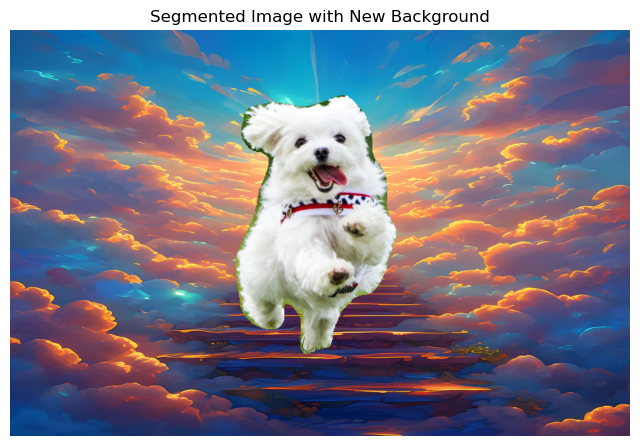

array([[[ 22,  87, 143],
        [ 22,  87, 143],
        [ 22,  87, 143],
        ...,
        [ 35,  87, 144],
        [ 36,  87, 144],
        [ 36,  87, 144]],

       [[ 22,  87, 143],
        [ 22,  87, 143],
        [ 22,  87, 143],
        ...,
        [ 35,  87, 144],
        [ 35,  87, 144],
        [ 35,  87, 144]],

       [[ 22,  87, 143],
        [ 22,  87, 143],
        [ 22,  87, 143],
        ...,
        [ 34,  87, 144],
        [ 35,  87, 144],
        [ 35,  87, 144]],

       ...,

       [[  4,  63, 131],
        [  4,  63, 131],
        [  4,  63, 131],
        ...,
        [ 68,  42,  79],
        [ 68,  42,  79],
        [ 68,  42,  79]],

       [[  4,  63, 131],
        [  4,  63, 131],
        [  4,  63, 131],
        ...,
        [ 68,  42,  79],
        [ 68,  42,  79],
        [ 68,  42,  79]],

       [[  4,  63, 131],
        [  4,  63, 131],
        [  4,  63, 131],
        ...,
        [ 68,  42,  79],
        [ 68,  42,  79],
        [ 68,  42,  79]]

In [25]:
segment_and_replace_background("angel.jpeg", "heaven4.jpg", 12)


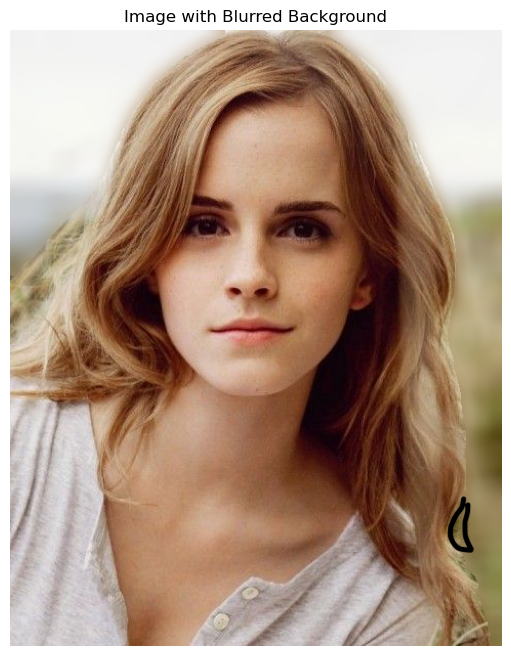

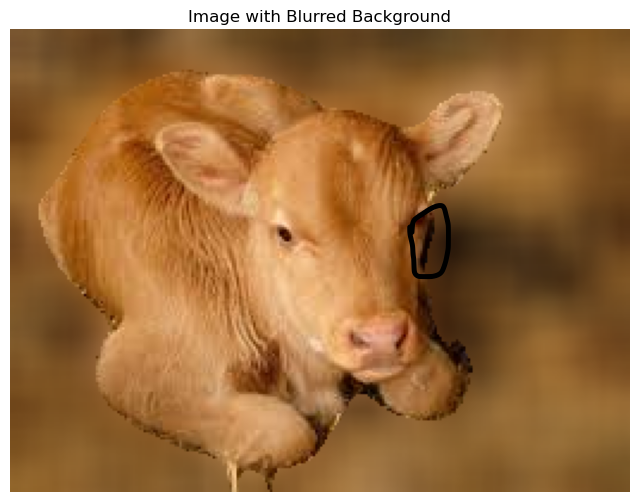

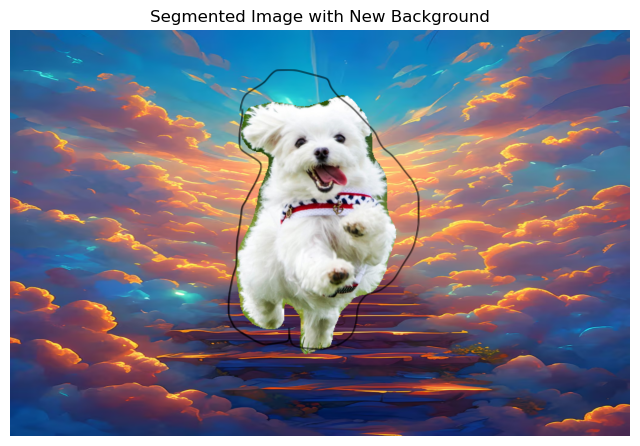

In [35]:
######Part 2: Problematic regions in the pictures

from IPython.display import Image
display(Image(filename='outfocusing_hum.png', width=400))
display(Image(filename='out_focusing_calf.png', width=400))
display(Image(filename='chroma_key_dog.png', width=400))

#### 문제제기
위에 사진 3개를 보면 공통점으로 타겟이 되는 대상 (예 사람)의 테두리 부분이 제대로 흐리게 나오지 않고 있던가 혹은 본래 사진의 색상 (강아지)이 마찬가지로 테두리 주변에 남아 있다는 문제점이 보입니다. 

#### 해결책 제안 
구글의 struct2Depth가 괜찮은 해결책이 되리라 생각됩니다. 
추론을 하면서 각 픽셀에 연속적인 값을 부여해서 이미지를 생성하기에 이미지의 픽셀이 이에 맞춰서 자연스럽게 흐리게 만들기 떄문에 (대상에 가까운 픽셀은 덜 약하게 흐리고 먼 픽셀은 더 강하게 흐리는 등) 기존 DeepLabV3 모델의 이진 분류의 특성상 생기는 문제로 부터 (예 칼같이 0 아니면 1로 나눔) 자유롭습니다. 
